# Matter-Antimatter asymmetries at the LHC

## Magnet Up/Down program

### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

### Input data
This opens input data files and assigns them to variables.

In [2]:
#path = '../Documents/University/Year 3/3rd Year Lab/UoM_MatterAntimatterLab-master/data_sets' # set this to '' to run on the GitHub version
events_sim = uproot.open('PhaseSpaceSimulation.root')
events_down = uproot.open('B2HHH_MagnetDown.root')
events_up = uproot.open('B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [3]:
# Check what's in the tree. 
# Note that the simulation tree is called 'PhaseSpaceTree' and does not have the ProbPi/K variables filled.
print('Input data variables:')
print(events_up['DecayTree'].keys())

# These are the arrays to hold the data
pT = []
pX = []
pY = []
pZ = []
m_pipipi = []
m_KKK = []
m_Kpipi = []
mKKlow = []
mKKhigh = []
mKpi = []
mpipi = []
mpipilow = []
mpipihigh = []
probK = []
probPi = []

###
char = []
m_KKK_p = []
m_KKK_m = []
m12KKsq_p = []
m23KKsq_p = []
m13KKsq_p=[]
mKKlow_p=[]
m12KKsq_m = []
m23KKsq_m = []
m13KKsq_m=[]
mKKhigh_m=[]
###

mpi = 140.
mK = 494.
mD = 1865.
mJp = 3097.
mp2S = 3686.
mB = 5280.
probK_all = 0.5 #0.5
probK_high = 0.8
probK_sum = 2.1
probK_max = 0.7
probpi_all = 0.6
probpi_sum2 = 1.3
probpi_sum = 2.4
mass_cut = 50. #50
mass_cut_D = 20. #20

# A counter for bookkeeping
event_counter = 0

# If set to a value greater than 0, limits the number of events analysed
MAX_EVENTS = -1

# This outer loop is a technical loop of uproot over chunks of events
#
#
#
# Magnet down+up data
#
#
for tree in [events_down[b'DecayTree'],events_up['DecayTree']]:
  for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
    # As Python can handle calculations with arrays, we can calculate derived quantities here
    
    #
    # Transverse Momentum
    pT_H1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
    pT_H2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
    pT_H3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)
    
    #
    # Engeries
    e_pi1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mpi**2)
    e_pi2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mpi**2)
    e_pi3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mpi**2)
    e_K1 = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mK**2)
    e_K2 = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mK**2)
    e_K3 = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mK**2)
    p12sq = (data[b'H1_PX']+data[b'H2_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ'])**2
    p23sq = (data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H2_PZ']+data[b'H3_PZ'])**2
    p13sq = (data[b'H1_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H3_PZ'])**2
    
    #
    # m12 and m23 are needed for "Dalitz Plot" later
    m12KKsq = (e_K1+e_K2)**2 - p12sq
    m23KKsq = (e_K3+e_K2)**2 - p23sq
    m13KKsq = (e_K1+e_K3)**2 - p13sq
    m12pipisq = (e_pi1+e_pi2)**2 - p12sq
    m23pipisq = (e_pi3+e_pi2)**2 - p23sq
    m13pipisq = (e_pi1+e_pi3)**2 - p13sq
    m12Kpisq = (e_K1+e_pi2)**2 - p12sq
    m23Kpisq = (e_K3+e_pi2)**2 - p23sq
    m13Kpisq = (e_K1+e_pi3)**2 - p13sq
    m12piKsq = (e_pi1+e_K2)**2 - p12sq
    m23piKsq = (e_pi3+e_K2)**2 - p23sq
    m13piKsq = (e_pi1+e_K3)**2 - p13sq
    
    #
    # Invariant mass calculations
    # 
    # sum of vector momentum and square
    psq = (data[b'H1_PX']+data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ']+data[b'H3_PZ'])**2
    # using M_inv = sqrt( sum(energies of 3 K)^2 - sum(vector momentum)^2)
    mKKKinv = np.sqrt((e_K1+e_K2+e_K3)**2 - psq)
    mpipipiinv = np.sqrt((e_pi1+e_pi2+e_pi3)**2 - psq)
    mKpipiinv = np.sqrt((e_K1+e_pi2+e_pi3)**2 - psq)
    mpiKpiinv = np.sqrt((e_pi1+e_K2+e_pi3)**2 - psq)
    mpipiKinv = np.sqrt((e_pi1+e_pi2+e_K3)**2 - psq)
    
    
    ###
    char = data[b'H1_Charge'] + data[b'H2_Charge'] + data[b'H3_Charge']
    ###
    
    
    
    #
    #
    # This loop will go over individual events
    for i in range(0,len(data[b'H1_PZ'])):
        event_counter += 1
        if 0 < MAX_EVENTS and MAX_EVENTS < event_counter: break
        if 0 == (event_counter % 100000): print('Read', event_counter, 'events')
        # Decide here which events to analyse
        if (data[b'H1_PZ'][i] < 0) or (data[b'H2_PZ'][i] < 0) or (data[b'H3_PZ'][i] < 0): continue
        if data[b'H1_isMuon'][i] or data[b'H2_isMuon'][i] or data[b'H3_isMuon'][i]: continue
        # Fill arrays of events to be plotted and analysed further below
        # Adding values for all three hadrons to the same variable here
        pT.append(pT_H1[i])
        pT.append(pT_H2[i])
        pT.append(pT_H3[i])
        pX.append(data[b'H1_PX'][i])
        pX.append(data[b'H2_PX'][i])
        pX.append(data[b'H3_PX'][i])
        pY.append(data[b'H1_PY'][i])
        pY.append(data[b'H2_PY'][i])
        pY.append(data[b'H3_PY'][i])
        pZ.append(data[b'H1_PZ'][i])
        pZ.append(data[b'H2_PZ'][i])
        pZ.append(data[b'H3_PZ'][i])
        probK.append(data[b'H1_ProbK'][i])
        probPi.append(data[b'H1_ProbPi'][i])
        probK.append(data[b'H2_ProbK'][i])
        probPi.append(data[b'H2_ProbPi'][i])
        probK.append(data[b'H3_ProbK'][i])
        probPi.append(data[b'H3_ProbPi'][i])
        
        if ((data[b'H1_ProbK'][i] > probK_all) 
            and (data[b'H2_ProbK'][i] > probK_all) 
            and (data[b'H3_ProbK'][i] > probK_all)
            and (data[b'H1_ProbK'][i] + data[b'H2_ProbK'][i] + data[b'H3_ProbK'][i] > probK_sum)):
            
            
            if char[i] == 1:
                m_KKK_p.append(mKKKinv[i])
                m12KKsq_p.append(m12KKsq[i])
                m23KKsq_p.append(m23KKsq[i])
                            
            elif char[i] == -1:
                m_KKK_m.append(mKKKinv[i])
                m12KKsq_m.append(m12KKsq[i])
                m23KKsq_m.append(m23KKsq[i])                  
            
            
            if data[b'H1_Charge'][i] == data[b'H2_Charge'][i]:
                #if np.abs(mKKKinv[i]-mB) < mass_cut:
                    #m_KKK.append(mKKKinv[i])
                m_KKK.append(mKKKinv[i])
                if (np.abs(mKKKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23KKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m13KKsq[i])-mD) > mass_cut_D):
                    if m13KKsq[i] > m23KKsq[i]:
                        mKKlow.append(m23KKsq[i])
                        mKKhigh.append(m13KKsq[i])
                    else:
                        mKKlow.append(m13KKsq[i])
                        mKKhigh.append(m23KKsq[i])
            elif data[b'H1_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mKKKinv[i]-mB) < mass_cut:
                    #m_KKK.append(mKKKinv[i])
                m_KKK.append(mKKKinv[i])
                if (np.abs(mKKKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23KKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12KKsq[i])-mD) > mass_cut_D):
                    if m12KKsq[i] > m23KKsq[i]:
                        mKKlow.append(m23KKsq[i])
                        mKKhigh.append(m12KKsq[i])
                    else:
                        mKKlow.append(m12KKsq[i])
                        mKKhigh.append(m23KKsq[i])
            elif data[b'H2_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mKKKinv[i]-mB) < mass_cut:
                    #m_KKK.append(mKKKinv[i])
                m_KKK.append(mKKKinv[i])
                if (np.abs(mKKKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13KKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12KKsq[i])-mD) > mass_cut_D):
                    if m12KKsq[i] > m13KKsq[i]:
                        mKKlow.append(m13KKsq[i])
                        mKKhigh.append(m12KKsq[i])
                    else:
                        mKKlow.append(m12KKsq[i])
                        mKKhigh.append(m13KKsq[i])
                        

        elif ((data[b'H1_ProbPi'][i] > probpi_all) 
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H1_ProbK'][i] < probK_max)
              and (data[b'H2_ProbK'][i] < probK_max)
              and (data[b'H3_ProbK'][i] < probK_max)
              and (data[b'H1_ProbPi'][i] + data[b'H2_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum)):
            if data[b'H1_Charge'][i] == data[b'H2_Charge'][i]:
                #if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    #m_pipipi.append(mpipipiinv[i])
                m_pipipi.append(mpipipiinv[i])
                if (np.abs(mpipipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13pipisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23pipisq[i])-mD) > mass_cut_D): 
                    if m13pipisq[i] > m23pipisq[i]:
                        mpipilow.append(m23pipisq[i])
                        mpipihigh.append(m13pipisq[i])
                    else:
                        mpipilow.append(m13pipisq[i])
                        mpipihigh.append(m23pipisq[i])
            elif data[b'H1_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    #m_pipipi.append(mpipipiinv[i])
                m_pipipi.append(mpipipiinv[i])
                if (np.abs(mpipipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m12pipisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23pipisq[i])-mD) > mass_cut_D): 
                    if m12pipisq[i] > m23pipisq[i]:
                        mpipilow.append(m23pipisq[i])
                        mpipihigh.append(m12pipisq[i])
                    else:
                        mpipilow.append(m12pipisq[i])
                        mpipihigh.append(m23pipisq[i])
            elif data[b'H2_Charge'][i] == data[b'H3_Charge'][i]:
                #if np.abs(mpipipiinv[i]-mB) < mass_cut:
                    #m_pipipi.append(mpipipiinv[i])
                m_pipipi.append(mpipipiinv[i])
                if (np.abs(mpipipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13pipisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12pipisq[i])-mD) > mass_cut_D): 
                    if m12pipisq[i] > m13pipisq[i]:
                        mpipilow.append(m13pipisq[i])
                        mpipihigh.append(m12pipisq[i])
                    else:
                        mpipilow.append(m12pipisq[i])
                        mpipihigh.append(m13pipisq[i])
       
    
        elif ((data[b'H1_ProbK'][i] > data[b'H2_ProbK'][i]) and (data[b'H1_ProbK'][i] > data[b'H3_ProbK'][i])
              and (data[b'H2_Charge'][i] != data[b'H3_Charge'][i])
              and (data[b'H1_ProbK'][i] > probK_high)
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H2_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum2)):
            if (data[b'H1_Charge'][i] != data[b'H2_Charge'][i]):
                #if np.abs(mKpipiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mKpipiinv[i])
                m_Kpipi.append(mKpipiinv[i])
                if (np.abs(mKpipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m12Kpisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23Kpisq[i])-mD) > mass_cut_D):
                    mKpi.append(m12Kpisq[i])
                    mpipi.append(m23pipisq[i])
            else:
                #if np.abs(mKpipiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mKpipiinv[i])
                m_Kpipi.append(mKpipiinv[i])
                if (np.abs(mKpipiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13Kpisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m23Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m13Kpisq[i])
                    mpipi.append(m23pipisq[i])

        elif ((data[b'H2_ProbK'][i] > data[b'H1_ProbK'][i]) and (data[b'H2_ProbK'][i] > data[b'H3_ProbK'][i])
              and (data[b'H1_Charge'][i] != data[b'H3_Charge'][i])
              and (data[b'H2_ProbK'][i] > probK_high)
              and (data[b'H1_ProbPi'][i] > probpi_all) 
              and (data[b'H3_ProbPi'][i] > probpi_all)
              and (data[b'H1_ProbPi'][i] + data[b'H3_ProbPi'][i] > probpi_sum2)):
            if (data[b'H2_Charge'][i] != data[b'H1_Charge'][i]):
                #if np.abs(mpiKpiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpiKpiinv[i])
                m_Kpipi.append(mpiKpiinv[i])
                if (np.abs(mpiKpiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m12piKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m13piKsq[i])-mD) > mass_cut_D): 
                    mKpi.append(m12piKsq[i])
                    mpipi.append(m13pipisq[i])
            else:
                #if np.abs(mpiKpiinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpiKpiinv[i])
                m_Kpipi.append(mpiKpiinv[i])
                if (np.abs(mpiKpiinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23Kpisq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m13Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m23Kpisq[i])
                    mpipi.append(m13pipisq[i])

        elif ((data[b'H3_ProbK'][i] > data[b'H2_ProbK'][i]) and (data[b'H3_ProbK'][i] > data[b'H1_ProbK'][i])
              and (data[b'H1_Charge'][i] != data[b'H2_Charge'][i])
              and (data[b'H3_ProbK'][i] > probK_high)
              and (data[b'H2_ProbPi'][i] > probpi_all) 
              and (data[b'H1_ProbPi'][i] > probpi_all)
              and (data[b'H2_ProbPi'][i] + data[b'H1_ProbPi'][i] > probpi_sum2)):
            if (data[b'H3_Charge'][i] != data[b'H1_Charge'][i]):
                #if np.abs(mpipiKinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpipiKinv[i])
                m_Kpipi.append(mpipiKinv[i])
                if (np.abs(mpipiKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m13piKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m13piKsq[i])
                    mpipi.append(m12pipisq[i])
            else:
                #if np.abs(mpipiKinv[i]-mB) < mass_cut: 
                    #m_Kpipi.append(mpipiKinv[i])
                m_Kpipi.append(mpipiKinv[i])
                if (np.abs(mpipiKinv[i]-mB) < mass_cut) and (np.abs(np.sqrt(m23piKsq[i])-mD) > mass_cut_D) and (np.abs(np.sqrt(m12Kpisq[i])-mD) > mass_cut_D): 
                    mKpi.append(m23piKsq[i])
                    mpipi.append(m12pipisq[i])
                    
 
print('Read {:d} events'.format(event_counter))

Input data variables:
[b'B_FlightDistance', b'B_VertexChi2', b'H1_PX', b'H1_PY', b'H1_PZ', b'H1_ProbK', b'H1_ProbPi', b'H1_Charge', b'H1_IPChi2', b'H1_isMuon', b'H2_PX', b'H2_PY', b'H2_PZ', b'H2_ProbK', b'H2_ProbPi', b'H2_Charge', b'H2_IPChi2', b'H2_isMuon', b'H3_PX', b'H3_PY', b'H3_PZ', b'H3_ProbK', b'H3_ProbPi', b'H3_Charge', b'H3_IPChi2', b'H3_isMuon']
Read 100000 events
Read 200000 events
Read 300000 events
Read 400000 events
Read 500000 events
Read 600000 events
Read 700000 events
Read 800000 events
Read 900000 events
Read 1000000 events
Read 1100000 events
Read 1200000 events
Read 1300000 events
Read 1400000 events
Read 1500000 events
Read 1600000 events
Read 1700000 events
Read 1800000 events
Read 1900000 events
Read 2000000 events
Read 2100000 events
Read 2200000 events
Read 2300000 events
Read 2400000 events
Read 2500000 events
Read 2600000 events
Read 2700000 events
Read 2800000 events
Read 2900000 events
Read 3000000 events
Read 3100000 events
Read 3200000 events
Read 330000

In [4]:
for tree in [events_sim['PhaseSpaceTree']]:
    for data in tree.iterate([b'H*_P[XYZ]',b'H*_Charge',b'H*_Prob*',b'H*_isMuon']):
        pT_H1_sim = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2)
        pT_H2_sim = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2)
        pT_H3_sim = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2)
        
        e_K1_sim = np.sqrt(data[b'H1_PX']**2+data[b'H1_PY']**2+data[b'H1_PZ']**2+mK**2)
        e_K2_sim = np.sqrt(data[b'H2_PX']**2+data[b'H2_PY']**2+data[b'H2_PZ']**2+mK**2)
        e_K3_sim = np.sqrt(data[b'H3_PX']**2+data[b'H3_PY']**2+data[b'H3_PZ']**2+mK**2)
        
        psq_sim = (data[b'H1_PX']+data[b'H2_PX']+data[b'H3_PX'])**2 + (data[b'H1_PY']+data[b'H2_PY']+data[b'H3_PY'])**2 + (data[b'H1_PZ']+data[b'H2_PZ']+data[b'H3_PZ'])**2
        
        mKKKinv_sim = np.sqrt((e_K1_sim+e_K2_sim+e_K3_sim)**2 - psq_sim)

### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

#### Histograms of Probabilities:

Plotting 1D probability histograms, it may take several minutes.


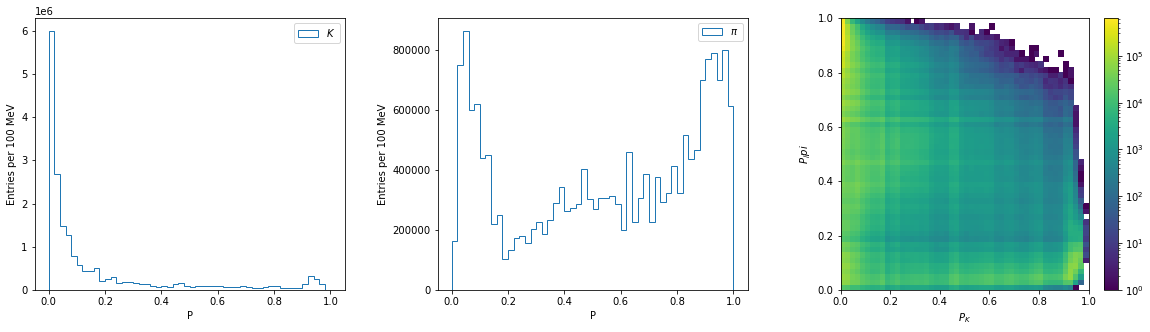

In [5]:
#
# Probabilities Plots
#
print('Plotting 1D probability histograms, it may take several minutes.')
#
# Figure Group Size
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)
#
# 1D histogram of probK
values_probK,bins_probK,patches_probK = ax[0].hist(probK, bins=50, range=[0,1], histtype='step', label='$K$')
ax[0].set_xlabel('P')
ax[0].set_ylabel('Entries per 100 MeV') # What label????
ax[0].legend()
#ax[0].legend()
#plt.savefig('figures/1d_his_probK.pdf')
#
# 1D histogram of probPi
values_probK,bins_probK,patches_probK = ax[1].hist(probPi, bins=50, range=[0,1], histtype='step', label='$\pi$')
ax[1].set_xlabel('P')
ax[1].set_ylabel('Entries per 100 MeV') # What label????
ax[1].legend()
#ax[1].legend()
#plt.savefig('figures/1d_his_probPi.pdf')
#
# 2D histogram of probK and probPi
h2d = ax[2].hist2d(probK, probPi, bins = [50,50], range = [[0,1],[0,1]],norm=colors.LogNorm())
ax[2].set_xlabel('$P_K$')
ax[2].set_ylabel('$P_/pi$')
fig.colorbar(h2d[3],ax=ax[2]) # let's add the colour scale
plt.savefig('figures/probabilities.pdf')
#

#### Histogram of Momentum

Plotting 1D histogram


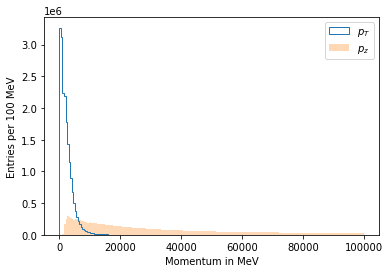

<Figure size 432x288 with 0 Axes>

In [6]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = plt.hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
plt.hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
plt.xlabel('Momentum in MeV')
plt.ylabel('Entries per 100 MeV')
plt.legend()
plt.show()
plt.savefig('figures/pTpZ.pdf')

#### Two-body Resonances

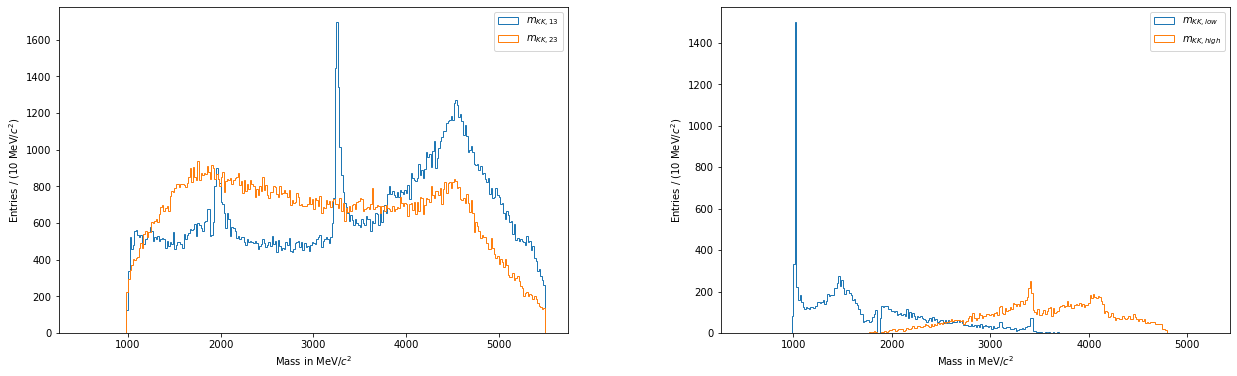

In [7]:
#
# Two-body Resonances
#
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
ax[0].hist(np.sqrt(m13KKsq), bins = 300, range = [500, 5500],histtype='step',label='$m_{KK,13}$')
ax[0].hist(np.sqrt(m23KKsq), bins = 300, range = [500, 5500],histtype='step',label='$m_{KK,23}$')

ax[1].hist(np.sqrt(mKKlow), bins = 300, range = [500, 5200],histtype='step',label='$m_{KK,low}$')
ax[1].hist(np.sqrt(mKKhigh), bins = 300, range = [500, 5200],histtype='step',label='$m_{KK,high}$')


ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries / (10 MeV/$c^2$)')
ax[0].legend()
#plt.savefig('figures/resonances/mKK.pdf')
ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries / (10 MeV/$c^2$)')
ax[1].legend()
#plt.savefig('figures/resonances/mpipi.pdf')
plt.savefig('figures/twobody_resonances.pdf')

#### Global Asymmetry Plot

Plotting Histrogram for B+ and B-: 
Number of B^+ decay:  394.0
Number of B^- decay:  368.0
Global CP Asymmetry:  -0.03412073490813648 +/- 0.03620508395604422


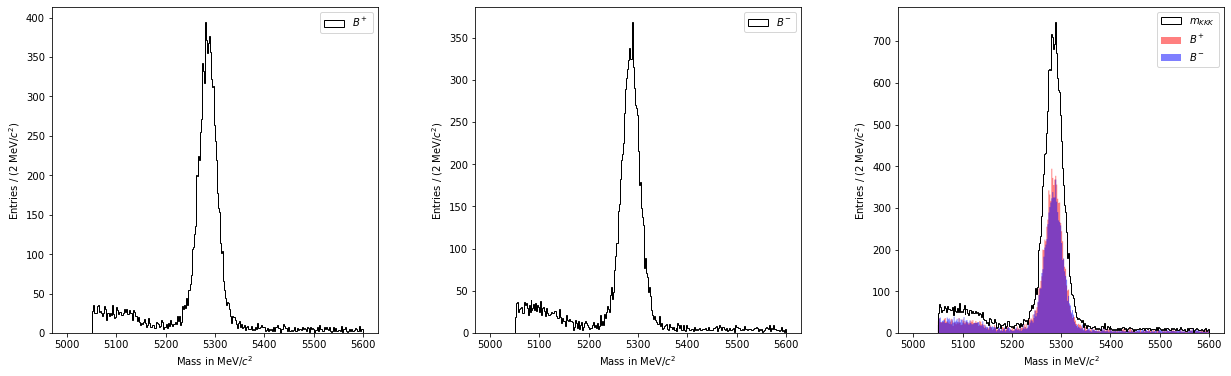

In [8]:
print('Plotting Histrogram for B+ and B-: ')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

values_m_KKK_p,bins_m_KKK_p,patches_m_KKK_p = ax[0].hist(m_KKK_p, bins = 300, range = [5000, 5600],histtype='step',label='$B^+$',color='black')
nBp = values_m_KKK_p.max()
print('Number of B^+ decay: ',nBp)

values_m_KKK_m,bins_m_KKK_m,patches_m_KKK_m = ax[1].hist(m_KKK_m, bins = 300, range = [5000, 5600],histtype='step',label='$B^-$',color='black')
nBm = values_m_KKK_m.max()
print('Number of B^- decay: ',nBm)

values_mKKK,bins_mKKK,patches_mKKK = ax[2].hist(m_KKK, bins = 300, range = [5000, 5600],histtype='step',label='$m_{KKK}$',color='black')
ax[2].hist(m_KKK_p, bins = 300, range = [5000, 5600],histtype='stepfilled',alpha=0.5,label='$B^+$',color='red')
ax[2].hist(m_KKK_m, bins = 300, range = [5000, 5600],histtype='stepfilled',alpha=0.5,label='$B^-$',color='blue')

ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries / (2 MeV/$c^2$)')
ax[0].legend()

ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries / (2 MeV/$c^2$)')
ax[1].legend()

ax[2].set_xlabel('Mass in MeV/$c^2$')
ax[2].set_ylabel('Entries / (2 MeV/$c^2$)')
ax[2].legend()

plt.savefig('figures/mass_inv_bm_bp.pdf')

#Global CP Asymmetry
gAsy = (nBm-nBp)/(nBm+nBp)
gAsyErr = np.sqrt( (1-(gAsy**2)) / (nBm+nBp) )
print('Global CP Asymmetry: ', gAsy, '+/-', gAsyErr)

#### Invariant Mass Plot

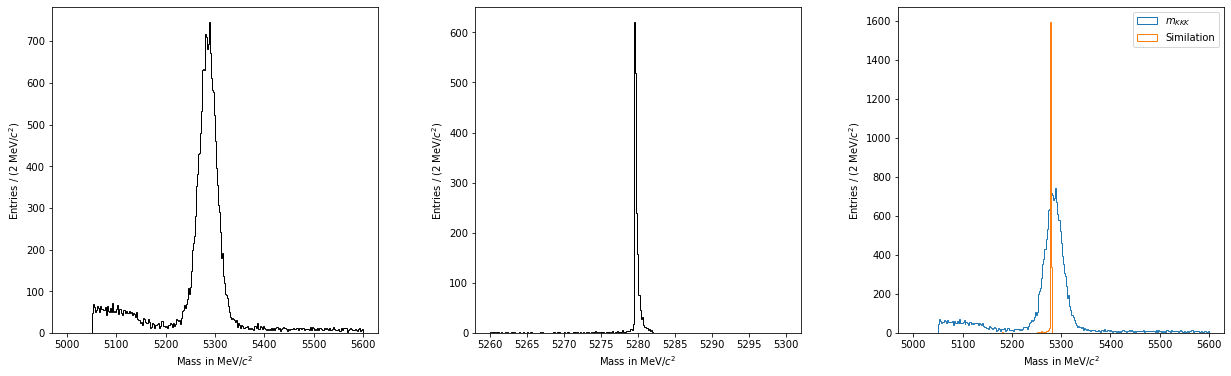

In [9]:
#
# 1D histogram of masses mKKK, mpipipi and mKpipi
#
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

values_mKKK,bins_mKKK,patches_mKKK = ax[0].hist(m_KKK, bins = 300, range = [5000, 5600],histtype='step',color='black')
values_mKKK_sim,bins_mKKK_sim,patches_mKKK_sim = ax[1].hist(mKKKinv_sim, bins = 300, range = [5260, 5300],histtype='step',color='black')

ax[2].hist(m_KKK, bins = 300, range = [5000, 5600],histtype='step',label='$m_{KKK}$')
ax[2].hist(mKKKinv_sim, bins = 300, range = [5000, 5600],histtype='step',label='Similation')

ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries / (2 MeV/$c^2$)')
#ax[0].set_title('$m_{inv}$ of B Meson')

ax[1].set_xlabel('Mass in MeV/$c^2$')
ax[1].set_ylabel('Entries / (2 MeV/$c^2$)')
#ax[1].set_title('Simulated $m_{inv}$ of B Meson')

ax[2].set_xlabel('Mass in MeV/$c^2$')
ax[2].set_ylabel('Entries / (2 MeV/$c^2$)')
ax[2].legend()

plt.savefig('figures/mass_inv_zoom.pdf')

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

Fit results with chi2/ndf 465.7401576168945 / 300
Par 1: 1698.967099 +/- 406.237039
Par 2: 28.916220 +/- 4.938274
Par 3: 25419.630893 +/- 143.045812
Par 4: 5284.958143 +/- 0.092974
Par 5: 17.448523 +/- 0.099926
Par 6: 32.807824 +/- 4.922254
Par 7: 378.059063 +/- 60.654275


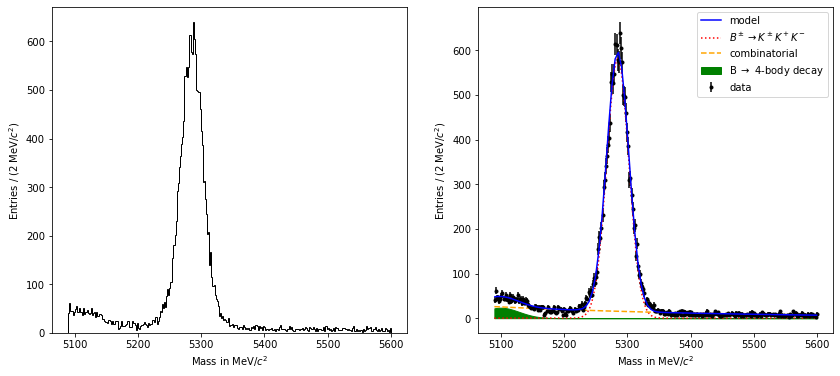

In [10]:
# decaying exponential function
def exponential(x, norm, decay):
    return np.array( norm * np.exp(-(x-5000)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# Gaussian function
def gauss(x, norm, mu, sigma):
    return np.array( norm / np.sqrt(2*np.pi) / sigma * np.exp( -(x-mu)**2 / 2 / sigma**2 ) )


# fit function combining two individual functions
def fit_function(x, norm4, sigma4, normG, muG, sigmaG, normE, decay):
    return np.array( gauss(x, norm4, 5100, sigma4) + gauss(x, normG, muG, sigmaG) + exponential(x, normE, decay) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays

    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)

    # execute the fit with starting values 5000 and 10^-4
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))
        
def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='data')
    
    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
    a.plot(x_fit,y_fit,label='model',color='b',zorder=10) # zorder makes sure the fit line is on top
    
    #plot all fitted lines
    a.fill_between(np.linspace(5090,5600,5000), gauss(np.linspace(5090,5600,5000), coeff_fit[0], 5100, coeff_fit[1]), color='green', label=r'B $\rightarrow$ 4-body decay')
    a.plot(np.linspace(5090,5600,5000), gauss(np.linspace(5090,5600,5000), coeff_fit[2], coeff_fit[3], coeff_fit[4]), linestyle=':', color='red', label=r'$B^\pm \rightarrow K^\pm K^+ K^-$')
    a.plot(np.linspace(5090,5600,5000), exponential(np.linspace(5090,5600,5000), coeff_fit[5], coeff_fit[6]),linestyle='--', color='orange',label='combinatorial')
    
    # plot decoration
    a.legend()
    a.set_xlabel('Mass in MeV/$c^2$')
    a.set_ylabel('Entries / (2 MeV/$c^2$)')
    plt.savefig(fname)



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))    

values_mKKK_forfit,bins_mKKK_forfit,patches_mKKK_forfit = ax[0].hist(m_KKK, bins = 300, range = [5090, 5600],histtype='step',color='black')
ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries / (2 MeV/$c^2$)')

coeff_KKK_fit,cov_KKK_fit, bin_centres_KKK, bin_centres_red_KKK, chi2_KKK, ndf_KKK = fit_data( bins_mKKK_forfit, values_mKKK_forfit, 5090, 5600, [2000,30,60000,5285,20,100,2000] ) #500
#coeff_pipipi_fit,cov_pipipi_fit, bin_centres_pipipi, bin_centres_red_pipipi, chi2_pipipi, ndf_pipipi = fit_data( bins_mpipipi, values_mpipipi, 5100, 5500, [5000,30,10000,5285,20,1000,1000] )
#coeff_Kpipi_fit,cov_Kpipi_fit, bin_centres_Kpipi, bin_centres_red_Kpipi, chi2_Kpipi, ndf_Kpipi = fit_data( bins_mKpipi, values_mKpipi, 5100, 5500, [15000,30,60000,5285,20,500,1600] )

print_results(coeff_KKK_fit,cov_KKK_fit, chi2_KKK, ndf_KKK)
#print_results(coeff_pipipi_fit,cov_pipipi_fit, chi2_pipipi, ndf_pipipi)
#print_results(coeff_Kpipi_fit,cov_Kpipi_fit, chi2_Kpipi, ndf_Kpipi)

# plot results


plot_results(ax[1],bin_centres_KKK,bin_centres_red_KKK,values_mKKK_forfit,coeff_KKK_fit,'figures/mfit_KKK.pdf')
#plot_results(ax[1],bin_centres_pipipi,bin_centres_red_pipipi,values_mpipipi,coeff_pipipi_fit,'figures/mfit_pipipi.pdf')
#plot_results(ax[2],bin_centres_Kpipi,bin_centres_red_Kpipi,values_mKpipi,coeff_Kpipi_fit,'figures/mfit_Kpipi.pdf')



#### Fitting B-

Fit results with chi2/ndf 495.4557130739993 / 300
Par 1: 1005.565286 +/- 283.350802
Par 2: 29.671761 +/- 5.985677
Par 3: 12120.920563 +/- 99.647174
Par 4: 5284.994267 +/- 0.135508
Par 5: 17.579222 +/- 0.146253
Par 6: 14.428213 +/- 3.220596
Par 7: 416.775305 +/- 106.503448


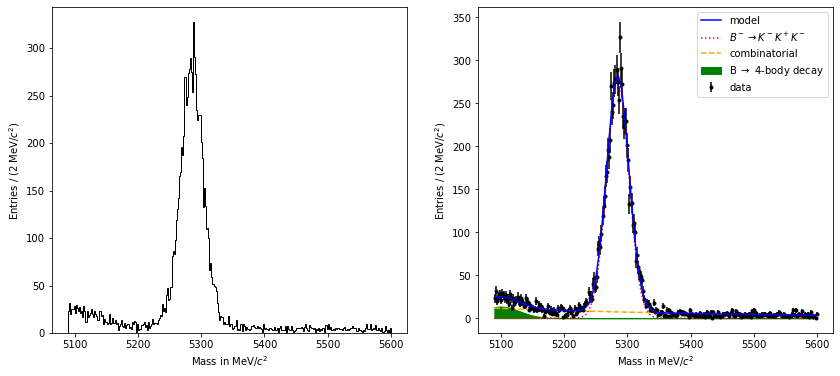

In [11]:
# Plot B- fit       
def plot_results_m(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='data')
    
    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
    a.plot(x_fit,y_fit,label='model',color='b',zorder=10) # zorder makes sure the fit line is on top
    
    #plot all fitted lines
    a.fill_between(np.linspace(5090,5600,5000), gauss(np.linspace(5090,5600,5000), coeff_fit[0], 5100, coeff_fit[1]), color='green', label=r'B $\rightarrow$ 4-body decay')
    a.plot(np.linspace(5090,5600,5000), gauss(np.linspace(5090,5600,5000), coeff_fit[2], coeff_fit[3], coeff_fit[4]), linestyle=':', color='red', label=r'$B^- \rightarrow K^- K^+ K^-$')
    a.plot(np.linspace(5090,5600,5000), exponential(np.linspace(5090,5600,5000), coeff_fit[5], coeff_fit[6]),linestyle='--', color='orange',label='combinatorial')
    
    # plot decoration
    a.legend()
    a.set_xlabel('Mass in MeV/$c^2$')
    a.set_ylabel('Entries / (2 MeV/$c^2$)')
    plt.savefig(fname)
    

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

values_m_KKK_m_forfit,bins_m_KKK_m_forfit,patches_m_KKK_m_forfit = ax[0].hist(m_KKK_m, bins = 300, range = [5090, 5600],histtype='step',label='$B^-$',color='black')
ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries / (2 MeV/$c^2$)')

coeff_KKK_m_fit,cov_KKK_m_fit, bin_centres_KKK_m, bin_centres_red_KKK_m, chi2_KKK_m, ndf_KKK_m = fit_data( bins_m_KKK_m_forfit, values_m_KKK_m_forfit, 5090, 5600, [2000,30,60000,5285,20,100,2000] ) #500

print_results(coeff_KKK_m_fit,cov_KKK_m_fit, chi2_KKK_m, ndf_KKK_m)

# plot results
plot_results_m(ax[1],bin_centres_KKK_m,bin_centres_red_KKK_m,values_m_KKK_m_forfit,coeff_KKK_m_fit,'figures/mfit_KKK_m.pdf')

#### Fitting B+

Fit results with chi2/ndf 463.9578685441272 / 300
Par 1: 708.927212 +/- 256.807556
Par 2: 28.406125 +/- 7.324335
Par 3: 13302.257459 +/- 90.212563
Par 4: 5284.927329 +/- 0.112061
Par 5: 17.334163 +/- 0.120097
Par 6: 18.277362 +/- 3.272230
Par 7: 351.570089 +/- 64.089187


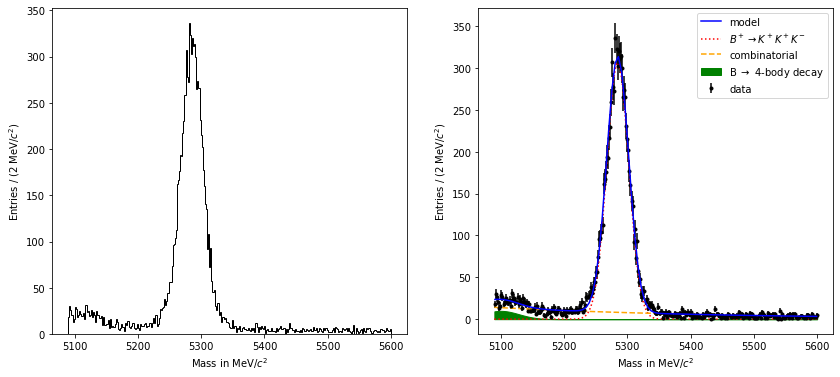

In [13]:
# Plot B+ fit
def plot_results_p(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='data')
    
    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2],coeff_fit[3],coeff_fit[4],coeff_fit[5],coeff_fit[6])
    a.plot(x_fit,y_fit,label='model',color='b',zorder=10) # zorder makes sure the fit line is on top
    
    #plot all fitted lines
    a.fill_between(np.linspace(5090,5600,5000), gauss(np.linspace(5090,5600,5000), coeff_fit[0], 5100, coeff_fit[1]), color='green', label=r'B $\rightarrow$ 4-body decay')
    a.plot(np.linspace(5090,5600,5000), gauss(np.linspace(5090,5600,5000), coeff_fit[2], coeff_fit[3], coeff_fit[4]), linestyle=':', color='red', label=r'$B^+ \rightarrow K^+ K^+ K^-$')
    a.plot(np.linspace(5090,5600,5000), exponential(np.linspace(5090,5600,5000), coeff_fit[5], coeff_fit[6]),linestyle='--', color='orange',label='combinatorial')
    
    # plot decoration
    a.legend()
    a.set_xlabel('Mass in MeV/$c^2$')
    a.set_ylabel('Entries / (2 MeV/$c^2$)')
    plt.savefig(fname)
    

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

values_m_KKK_p_forfit,bins_m_KKK_p_forfit,patches_m_KKK_p_forfit = ax[0].hist(m_KKK_p, bins = 300, range = [5090, 5600],histtype='step',label='$B^+$',color='black')
ax[0].set_xlabel('Mass in MeV/$c^2$')
ax[0].set_ylabel('Entries / (2 MeV/$c^2$)')

coeff_KKK_p_fit,cov_KKK_p_fit, bin_centres_KKK_p, bin_centres_red_KKK_p, chi2_KKK_p, ndf_KKK_p = fit_data( bins_m_KKK_p_forfit, values_m_KKK_p_forfit, 5090, 5600, [2000,30,60000,5285,20,100,2000] ) #500

print_results(coeff_KKK_p_fit,cov_KKK_p_fit, chi2_KKK_p, ndf_KKK_p)

# plot results
plot_results_p(ax[1],bin_centres_KKK_p,bin_centres_red_KKK_p,values_m_KKK_p_forfit,coeff_KKK_p_fit,'figures/mfit_KKK_p.pdf')